# PR8-2 Classificatiemodellen

## Opdracht

Great Outdoors wil graag weten wat de retourredenen gaan zijn op basis van een set onafhankelijke variabelen. Daarom wil zij een model trainen op basis van reeds bekende data, zodat deze volgend jaar in gebruik kan worden genomen. Let op: de retourreden kan ook "n.v.t." zijn, niet elke order wordt namelijk geretourneerd; je zult dit moeten aanpakken door een join tussen "returned_item" en "order_details". Je doet dus het volgende met de reeds bekende data:
- Bedenk met welke onafhankelijke variabelen dit naar verwachting het beste voorspeld kan worden en zet deze samen met de afhankelijke variabele in één DataFrame.
- Pas waar nodig Dummy Encoding toe.
- Snijd dit DataFrame horizontaal en verticaal op de juiste manier.
- Train het classificatiemodel.
- Evalueer de performance van je getrainde classificatiemodel a.d.h.v. een confusion matrix.

## Implementatie

### Library Imports

In [123]:
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import sqlite3
import csv
import pyodbc

### Data import en samenvoeging

In [124]:
sales_con = None
crm_con = None
staff_con = None
GO_SALES_PRODUCT_FORECASTData = None
GO_SALES_INVENTORY_LEVELSData = None



try : 
        sales_con = sqlite3.connect("../Assets/Week 2/go_sales.sqlite")
        print("Connected to go_sales sqlite.")


        crm_con = sqlite3.connect("../Assets/Week 2/go_crm.sqlite")
        print("Connected to go_crm sqlite.")


        staff_con = sqlite3.connect("../Assets/Week 2/go_staff.sqlite")
        print("Connected to go_staff sqlite.")

        GO_SALES_PRODUCT_FORECASTData = pd.read_csv("../Assets/Week 2/GO_SALES_PRODUCT_FORECASTData.csv")
        print("Connected to GO_SALES_PRODUCT_FORECASTData")

        GO_SALES_INVENTORY_LEVELSData = pd.read_csv("../Assets/Week 2/GO_SALES_INVENTORY_LEVELSData.csv", header=0, index_col=False)
        print("Connected to GO_SALES_INVENTORY_LEVELSData.csv")


except sqlite3.Error as error: 
        print("Failed to read data from sqlite table", error)

DataWarehouse_con = None

try : 
        pass
except : 
        pass




Connected to go_sales sqlite.
Connected to go_crm sqlite.
Connected to go_staff sqlite.
Connected to GO_SALES_PRODUCT_FORECASTData
Connected to GO_SALES_INVENTORY_LEVELSData.csv


In [125]:
global product
product = pd.read_sql_query("SELECT * FROM {}".format("product"),sales_con)
product = product[product.columns.drop(list(product.filter(regex="TRIAL")))]

global product_type
product_type = pd.read_sql_query("SELECT * FROM {}".format("product_type"),sales_con)
product_type = product_type[product_type.columns.drop(list(product_type.filter(regex="TRIAL")))]

global product_line
product_line = pd.read_sql_query("SELECT * FROM {}".format("product_line"),sales_con)
product_line = product_line[product_line.columns.drop(list(product_line.filter(regex="TRIAL")))]

global order_header
order_header = pd.read_sql_query("SELECT * FROM {}".format("order_header"),sales_con)
order_header = order_header[order_header.columns.drop(list(order_header.filter(regex="TRIAL")))]

global order_details
order_details = pd.read_sql_query("SELECT * FROM {}".format("order_details"),sales_con)
order_details = order_details[order_details.columns.drop(list(order_details.filter(regex="TRIAL")))]

global returned_item
returned_item = pd.read_sql_query("SELECT * FROM {}".format("returned_item"),sales_con)
returned_item = returned_item[returned_item.columns.drop(list(returned_item.filter(regex="TRIAL")))]





In [126]:
# DATATYPE CONVERSION AND DATAFRAME CONSTRUCTION

dataset = pd.merge(order_header, order_details, left_on="ORDER_NUMBER", how="inner", right_on="ORDER_NUMBER")
dataset = pd.merge(dataset, returned_item, left_on="ORDER_DETAIL_CODE", how="left", right_on="ORDER_DETAIL_CODE")



dataset["RETAILER_ID"] = pd.factorize(dataset['RETAILER_NAME'].tolist())[0]

dataset = dataset.loc[:, [
    # "RETAILER_ID",
    # "ORDER_DATE",
    # "RETURN_DATE",
    "ORDER_METHOD_CODE",
    # "PRODUCT_NUMBER",
    "RETURN_REASON_CODE",
    "QUANTITY",
    "RETURN_QUANTITY"
    ]]

# dataset["PRODUCT_NUMBER"] = dataset["PRODUCT_NUMBER"].astype(int)
dataset["ORDER_METHOD_CODE"] = dataset["ORDER_METHOD_CODE"].astype(int)
# dataset["ORDER_DATE"] = pd.to_datetime(dataset["ORDER_DATE"])
# dataset["RETURN_DATE"] = pd.to_datetime(dataset["RETURN_DATE"])
dataset["RETURN_REASON_CODE"] = dataset["RETURN_REASON_CODE"].fillna(6).astype(str)
dataset["RETURN_QUANTITY"] = dataset["RETURN_QUANTITY"].fillna(0).astype(int)
# dataset["RETURN_QUANTITY"] = dataset["RETURN_QUANTITY"].astype(float)


dataset = dataset.convert_dtypes()
print(dataset.dtypes)
dataset

# display(dataset.loc[(dataset["RETURN_QUANTIY"]>0),:])

ORDER_METHOD_CODE              Int32
RETURN_REASON_CODE    string[python]
QUANTITY                       Int64
RETURN_QUANTITY                Int32
dtype: object


C:\Users\arcde\AppData\Local\Temp\ipykernel_22732\2669394570.py:8: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  dataset["RETAILER_ID"] = pd.factorize(dataset['RETAILER_NAME'].tolist())[0]


,ORDER_METHOD_CODE,RETURN_REASON_CODE,QUANTITY,RETURN_QUANTITY
0,7,6,100,0
1,7,6,254,0
2,7,6,114,0
3,7,6,130,0
4,7,6,74,0
...,...,...,...,...
43058,5,6,64,0
43059,5,6,24,0
43060,5,6,40,0
43061,5,6,32,0


### One-hot encoding van niet-numerieke onafhankelijke variabelen

In [127]:
dummies_dataframe = pd.get_dummies(dataset.loc[:,["RETURN_REASON_CODE"]])

dummies_dataframe = dummies_dataframe.rename(columns= {
    "RETURN_REASON_CODE_1" : "Defective product",
    "RETURN_REASON_CODE_2" : "Incomplete product",
    "RETURN_REASON_CODE_3" : "Wrong product ordered",
    "RETURN_REASON_CODE_4" : "Wrong product shipped",
    "RETURN_REASON_CODE_5" : "Unsatisfactory product",
    "RETURN_REASON_CODE_6" : "Unreturned"
 })



print(f"{dummies_dataframe.dtypes}\n\n{dummies_dataframe.count()}")

Defective product         boolean
Incomplete product        boolean
Wrong product ordered     boolean
Wrong product shipped     boolean
Unsatisfactory product    boolean
Unreturned                boolean
dtype: object

Defective product         43063
Incomplete product        43063
Wrong product ordered     43063
Wrong product shipped     43063
Unsatisfactory product    43063
Unreturned                43063
dtype: int64


### Horizontaal en verticaal snijden

In [128]:
dataset = pd.concat([dataset, dummies_dataframe], axis=1)

dataset = dataset.drop(["RETURN_REASON_CODE"], axis=1)

dataset.dtypes

ORDER_METHOD_CODE           Int32
QUANTITY                    Int64
RETURN_QUANTITY             Int32
Defective product         boolean
Incomplete product        boolean
Wrong product ordered     boolean
Wrong product shipped     boolean
Unsatisfactory product    boolean
Unreturned                boolean
dtype: object

In [129]:
columns = ["Defective product",
           "Incomplete product",
           "Wrong product ordered",
           "Wrong product shipped",
           "Unsatisfactory product",
           "Unreturned"]

x_dataset = dataset.drop(columns, axis=1)
y_dataset = dataset.loc[:,columns]

# display(x_dataset)
# display(y_dataset)

# print(x_dataset.isnull().any())
# print(y_dataset.isnull().any())

display(x_dataset.describe())
display(y_dataset.describe())

,ORDER_METHOD_CODE,QUANTITY,RETURN_QUANTITY
count,43063.0,43063.0,43063.0
mean,4.273483,51.444488,0.332211
std,2.046112,59.70671,5.602975
min,1.0,2.0,0.0
25%,2.0,20.0,0.0
50%,4.0,36.0,0.0
75%,7.0,60.0,0.0
max,8.0,1646.0,492.0


,Defective product,Incomplete product,Wrong product ordered,Wrong product shipped,Unsatisfactory product,Unreturned
count,43063,43063,43063,43063,43063,43063
unique,2,2,2,2,2,2
top,False,False,False,False,False,True
freq,42821,42854,42993,43001,42940,42357


### Decision tree bouwen en evalueren

In [130]:
x_train, x_test, y_train, y_test = train_test_split(
    x_dataset,
    y_dataset,
    test_size=0.15, #Percentage van de datasets dat opzij wordt gezet voor test doeleinden
    random_state=42 #zorgt ervoor dat resultaten consistent blijven. Arbitrair nummer
)

# print(list(x_train.columns))
display(x_train)
# print(list(x_test.columns))

print(list(y_train.columns))
# print(list(y_test.columns))
# display(y_test.describe())
display(y_train)

,ORDER_METHOD_CODE,QUANTITY,RETURN_QUANTITY
2891,2,16,0
23026,5,10,0
3366,5,128,0
36010,2,58,0
10289,7,38,0
...,...,...,...
6265,3,22,0
11284,3,8,0
38158,4,28,0
860,2,46,0


['Defective product', 'Incomplete product', 'Wrong product ordered', 'Wrong product shipped', 'Unsatisfactory product', 'Unreturned']


,Defective product,Incomplete product,Wrong product ordered,Wrong product shipped,Unsatisfactory product,Unreturned
2891,False,False,False,False,False,True
23026,False,False,False,False,False,True
3366,False,False,False,False,False,True
36010,False,False,False,False,False,True
10289,False,False,False,False,False,True
...,...,...,...,...,...,...
6265,False,False,False,False,False,True
11284,False,False,False,False,False,True
38158,False,False,False,False,False,True
860,False,False,False,False,False,True


#### Depth=2

DecisionTreeClassifier(max_depth=2)


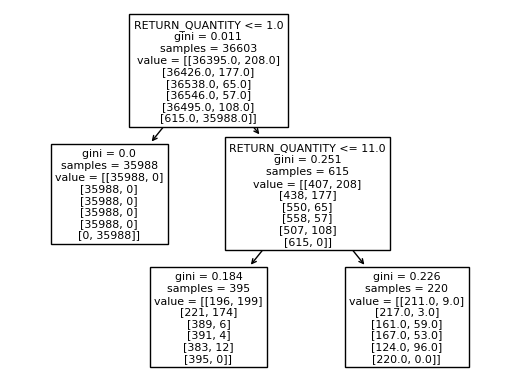

In [131]:
dtree = DecisionTreeClassifier(max_depth=2)
dtree = dtree.fit(x_train, y_train)
tree.plot_tree(dtree, feature_names= x_dataset.columns)

print(dtree)

plt.show()

In [132]:
prediction_DF = pd.DataFrame(dtree.predict(x_test))



prediction_DF = prediction_DF.rename(columns= 
                                     {
                                         0 : "DEFECTIVE",
                                         1 : "INCOMPLETE",
                                         2 : "WRONG_ORDER",
                                         3 : "WRONG_SHIPMENT",
                                         4 : "UNSATISFACTORY",
                                         5 : "UNRETURNED"
                                         }
                                     )
prediction_DF["DEFECTIVE"] = prediction_DF["DEFECTIVE"].astype(int)
prediction_DF["INCOMPLETE"] = prediction_DF["INCOMPLETE"].astype(int)
prediction_DF["WRONG_ORDER"] = prediction_DF["WRONG_ORDER"].astype(int)
prediction_DF["WRONG_SHIPMENT"] = prediction_DF["WRONG_SHIPMENT"].astype(int)
prediction_DF["UNSATISFACTORY"] = prediction_DF["UNSATISFACTORY"].astype(int)
prediction_DF["UNRETURNED"] = prediction_DF["UNRETURNED"].astype(int)



# display(prediction_DF)

y_test = y_test.reset_index(drop=True) 

y_test["Defective product"] = y_test["Defective product"].astype(int)
y_test["Incomplete product"] = y_test["Incomplete product"].astype(int)
y_test["Wrong product ordered"] = y_test["Wrong product ordered"].astype(int)
y_test["Wrong product shipped"] = y_test["Wrong product shipped"].astype(int)
y_test["Unsatisfactory product"] = y_test["Unsatisfactory product"].astype(int)
y_test["Unreturned"] = y_test["Unreturned"].astype(int)
# y_test = y_test.replace({True: 1, False: 0})
# display(y_test)


y_prediction_merge_test = pd.concat([
    y_test
    , prediction_DF], axis=1)

print(y_prediction_merge_test.dtypes)

# y_prediction_merge_test.describe()

# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     display(y_prediction_merge_test)

Defective product         int32
Incomplete product        int32
Wrong product ordered     int32
Wrong product shipped     int32
Unsatisfactory product    int32
Unreturned                int32
DEFECTIVE                 int32
INCOMPLETE                int32
WRONG_ORDER               int32
WRONG_SHIPMENT            int32
UNSATISFACTORY            int32
UNRETURNED                int32
dtype: object


[[  34    0    0    0    0    0]
 [  32    0    0    0    0    0]
 [   5    0    0    0    0    0]
 [   5    0    0    0    0    0]
 [  15    0    0    0    0    0]
 [   0    0    0    0    0 6369]]


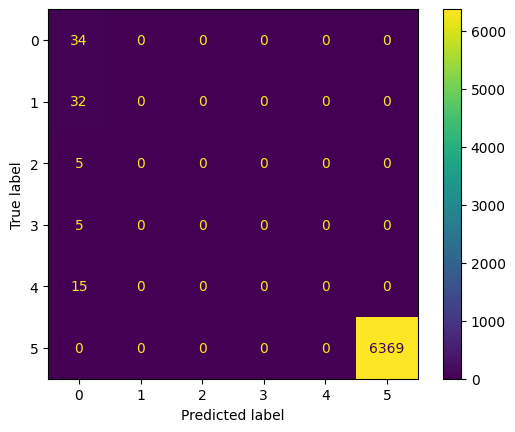

In [133]:

# dit was bedoeld om een 2x2 matrix te maken. Is dat wel nodig?
# def confusion_matrix(y_true, y_pred) :
#     tp = np.logical_and(y_pred == 1, y_true == 1).sum()
#     tn = np.logical_and(y_pred == 0, y_true == 0).sum()
#     fp = np.logical_and(y_pred == 1, y_true == 0).sum()
#     fn = np.logical_and(y_pred == 0, y_true == 1).sum()

#     return tp, tn, fp, fn

# display( confusion_matrix(y_test, prediction_DF))

confusion_matrix = metrics.confusion_matrix(y_test.values.argmax(axis=1), prediction_DF.values.argmax(axis=1))
print(confusion_matrix)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)


cm_display.plot()
plt.show()


In [134]:
metrics.accuracy_score(
    y_test#.values.argmax(axis=1)
    , prediction_DF#.values.argmax(axis=1)
    )

0.9907120743034056

#### Depth=MAX

In [135]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(x_train, y_train)
# tree.plot_tree(dtree, feature_names= x_dataset.columns)

print(dtree)

# plt.show()

DecisionTreeClassifier()


In [136]:
prediction_DF = pd.DataFrame(dtree.predict(x_test))



prediction_DF = prediction_DF.rename(columns= 
                                     {
                                         0 : "DEFECTIVE",
                                         1 : "INCOMPLETE",
                                         2 : "WRONG_ORDER",
                                         3 : "WRONG_SHIPMENT",
                                         4 : "UNSATISFACTORY"
                                         }
                                     )
prediction_DF["DEFECTIVE"] = prediction_DF["DEFECTIVE"].astype(int)
prediction_DF["INCOMPLETE"] = prediction_DF["INCOMPLETE"].astype(int)
prediction_DF["WRONG_ORDER"] = prediction_DF["WRONG_ORDER"].astype(int)
prediction_DF["WRONG_SHIPMENT"] = prediction_DF["WRONG_SHIPMENT"].astype(int)
prediction_DF["UNSATISFACTORY"] = prediction_DF["UNSATISFACTORY"].astype(int)



# display(prediction_DF)

y_test = y_test.reset_index(drop=True) 

y_test["Defective product"] = y_test["Defective product"].astype(int)
y_test["Incomplete product"] = y_test["Incomplete product"].astype(int)
y_test["Wrong product ordered"] = y_test["Wrong product ordered"].astype(int)
y_test["Wrong product shipped"] = y_test["Wrong product shipped"].astype(int)
y_test["Unsatisfactory product"] = y_test["Unsatisfactory product"].astype(int)
# y_test = y_test.replace({True: 1, False: 0})
# display(y_test)


y_prediction_merge_test = pd.concat([
    y_test
    , prediction_DF], axis=1)

print(y_prediction_merge_test.dtypes)

# y_prediction_merge_test.describe()

# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     display(y_prediction_merge_test)

Defective product           int32
Incomplete product          int32
Wrong product ordered       int32
Wrong product shipped       int32
Unsatisfactory product      int32
Unreturned                  int32
DEFECTIVE                   int32
INCOMPLETE                  int32
WRONG_ORDER                 int32
WRONG_SHIPMENT              int32
UNSATISFACTORY              int32
5                         float64
dtype: object


[[  16   17    1    0    0    0]
 [  19   13    0    0    0    0]
 [   1    0    1    0    3    0]
 [   1    0    1    0    3    0]
 [   2    0    2    6    5    0]
 [   0    0    0    0    0 6369]]


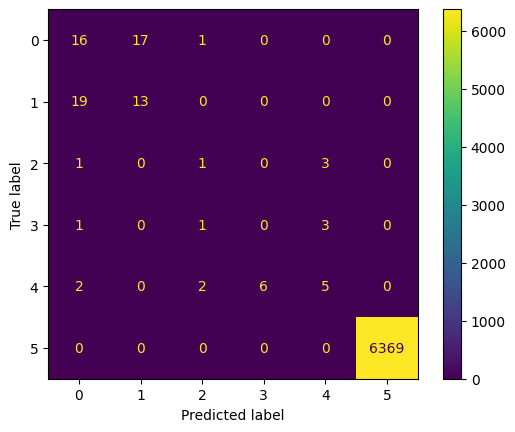

In [137]:
# y_true =  y_prediction_merge_test["RETURN_QUANTITY"]
# y_pred = y_prediction_merge_test["PREDICTED QUANTITY"]


confusion_matrix = metrics.confusion_matrix(y_test.values.argmax(axis=1), prediction_DF.values.argmax(axis=1))
print(confusion_matrix)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)


cm_display.plot()
plt.show()


In [138]:
metrics.accuracy_score(
    y_test#.values.argmax(axis=1)
    , prediction_DF#.values.argmax(axis=1)
    )

0.9908668730650155